In [ ]:
!pip install pickle5

In [ ]:
import numpy as np
import pandas as pd
import glob
from skimage.io import imread
from skimage.transform import resize
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import pickle5 as pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer,Conv2D,MaxPool2D,Flatten,Dropout,Dense
from tensorflow.keras.regularizers import l1_l2,l1,l2
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from keras import models
from tensorflow.keras.models import load_model

path="/content/drive/MyDrive/maestria_ciencia_datos/semestre1/mineria_y_analisis_de_datos/proyecto/"

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
image_names = glob.glob(path+'images/*.jpg')
len(image_names)

330

In [ ]:
X =  [resize(imread(img_name), (128, 128)) for img_name in image_names]

In [ ]:
X=np.array(X)

In [ ]:
X.shape

(330, 128, 128, 3)

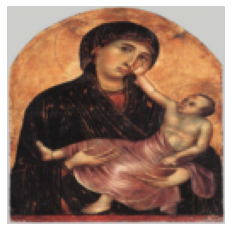

(128, 128, 3)


In [ ]:
i=0
plt.imshow(X[i])
plt.axis('off')
plt.show()
print(X[i].shape)

In [ ]:
infile=open(path+'dict_wikiarts.pkl', 'rb')
new_dict=pickle.load(infile)
infile.close()

Paintings = list(map(lambda x : x['Paintings'], new_dict))
Styles = list(map(lambda x : x['style'], new_dict))
Substyles = list(map(lambda x : x['substyle'], new_dict))

Title=[]
Style=[]
Substyle=[]
ID=[]
Year=[]
Image_URL=[]
Artist_Name=[]
np=0

for i in range (len(Paintings)):
    np=0
    for e in range (len(Paintings[i])):
        Title.append(Paintings[i][np]['title'])
        Style.append(Styles[i])
        Substyle.append(Substyles[i])
        ID.append(Paintings[i][np]['id'])
        Year.append(Paintings[i][np]['year'])
        Image_URL.append(Paintings[i][np]['image'])
        Artist_Name.append(Paintings[i][np]['artistName'])
        np+=1

Art = pd.DataFrame({'Title':Title, 'Artist Name':Artist_Name, 'Year':Year, 'Image URL':Image_URL,
                   "Style":Style,"Substyle":Substyle,"ID":ID})

muestra=Art[Art["Style"]=="Western Renaissance Art"].reset_index(drop=True)

In [ ]:
nombres=[x.split("/")[-1][:-4] for x in image_names]
tabla1=pd.DataFrame(nombres).rename(columns={0:"id"}).merge(muestra,left_on="id",right_on="ID",how="left")
tabla1.shape

(330, 8)

In [ ]:
tabla1["Substyle"].unique()

array(['Proto Renaissance', 'Early Renaissance', 'High Renaissance',
       'Mannerism (Late Renaissance)', 'Northern Renaissance',
       'Renaissance'], dtype=object)

In [ ]:
one = OneHotEncoder()
Y=one.fit_transform(tabla1["Substyle"].values.reshape(-1,1)).toarray()

In [ ]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.4,random_state=0)

X_train = X_train/255
X_test = X_test/255

In [ ]:
checkpoints = ModelCheckpoint(
                            path+"checkpoint_mejor_modelo_v1.h5",
                            monitor='val_accuracy', ## que funcion monitorea para crear el checkpoint
                            verbose=10, ## imprima que guardo un checpoint
                            save_best_only=True, ## solo guarde el mejor model
                            save_weights_only=False, ## Nos guarda la arquitectura y los pesos
                            mode="max", ### Cuando guardar el checkpoint, en este caso, cada nuevo minimo en la funcion de val_loss
                            save_freq='epoch') ### Cada cuando guarda el checkpoint

In [ ]:
model = Sequential()
model.add(InputLayer(input_shape=(128,128,3))) ## las dimensiones de la imagen, o las dimensiones de cada ejemplo
model.add(Conv2D(filters= 20 , kernel_size=(4,4), padding="same", activation = "relu" ))
model.add(MaxPool2D(pool_size=(2,2))) ## reducimos la imagen a la mitad de su tamaño 
model.add(Conv2D(filters= 50 , kernel_size=(3,3), padding="same", activation = "LeakyReLU" ))
model.add(MaxPool2D(pool_size=(2,2))) ## reducimos la imagen a la mitad de su tamaño 
model.add(Flatten()) ## convetimos un tensor de cualesquiera dimensiones a un vector 
model.add(Dropout(0.4))
model.add(Dense(units=128, activation ="relu"))
model.add(Dense(units=64, activation ="LeakyReLU", kernel_regularizer= l1_l2(0.001,0.001)))
#model.add(Dropout(0.3))

model.add(Dense(6, activation="softmax", kernel_regularizer= l1_l2(0.001,0.001))) ## capa de salida 

model.compile(loss=CategoricalCrossentropy(), optimizer=Adam(0.0005,), metrics= ["accuracy"])

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 128, 128, 20)      980       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 64, 64, 20)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 64, 64, 50)        9050      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 32, 32, 50)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 51200)             0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 51200)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)              

In [ ]:
history = model.fit(X_train,Y_train, epochs= 100, batch_size =64, validation_data=(X_test,Y_test),callbacks=[checkpoints])

Epoch 1/100
4/4 [==============================] - 5s 1s/step - loss: 2.6735 - accuracy: 0.2121 - val_loss: 2.6509 - val_accuracy: 0.1667

Epoch 00001: val_accuracy improved from -inf to 0.16667, saving model to /content/drive/MyDrive/maestria_ciencia_datos/semestre1/mineria_y_analisis_de_datos/proyecto/checkpoint_mejor_modelo_v2.h5
Epoch 2/100
4/4 [==============================] - 5s 1s/step - loss: 2.6443 - accuracy: 0.1919 - val_loss: 2.6294 - val_accuracy: 0.1667

Epoch 00002: val_accuracy did not improve from 0.16667
Epoch 3/100
4/4 [==============================] - 5s 1s/step - loss: 2.6238 - accuracy: 0.1919 - val_loss: 2.6185 - val_accuracy: 0.1667

Epoch 00003: val_accuracy did not improve from 0.16667
Epoch 4/100
4/4 [==============================] - 5s 1s/step - loss: 2.6089 - accuracy: 0.1919 - val_loss: 2.6010 - val_accuracy: 0.1667

Epoch 00004: val_accuracy did not improve from 0.16667
Epoch 5/100
4/4 [==============================] - 5s 1s/step - loss: 2.5942 - accu

In [ ]:
fig = go.Figure()
fig.add_trace( go.Scatter(x= list(range(len(history.history["loss"]))), y=history.history["loss"], mode="lines"))
fig.add_trace(go.Scatter(x= list(range(len(history.history["val_loss"]))), y=history.history["val_loss"], mode="lines"))
fig.show()

In [ ]:
fig = go.Figure()
fig.add_trace( go.Scatter(x= list(range(len(history.history["accuracy"]))), y=history.history["accuracy"], mode="lines"))
fig.add_trace(go.Scatter(x= list(range(len(history.history["val_accuracy"]))), y=history.history["val_accuracy"], mode="lines"))
fig.update_layout(dict(title="Accuracy"))
fig.show()

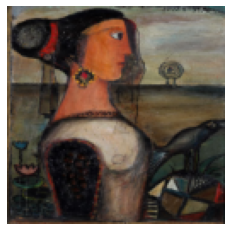

(128, 128, 3)
[0. 0. 0. 0. 0. 1.]


In [ ]:
i=14
plt.imshow(X_train[i]*255)
plt.axis('off')
plt.show()
print(X_train[i].shape)
print(Y_train[i])

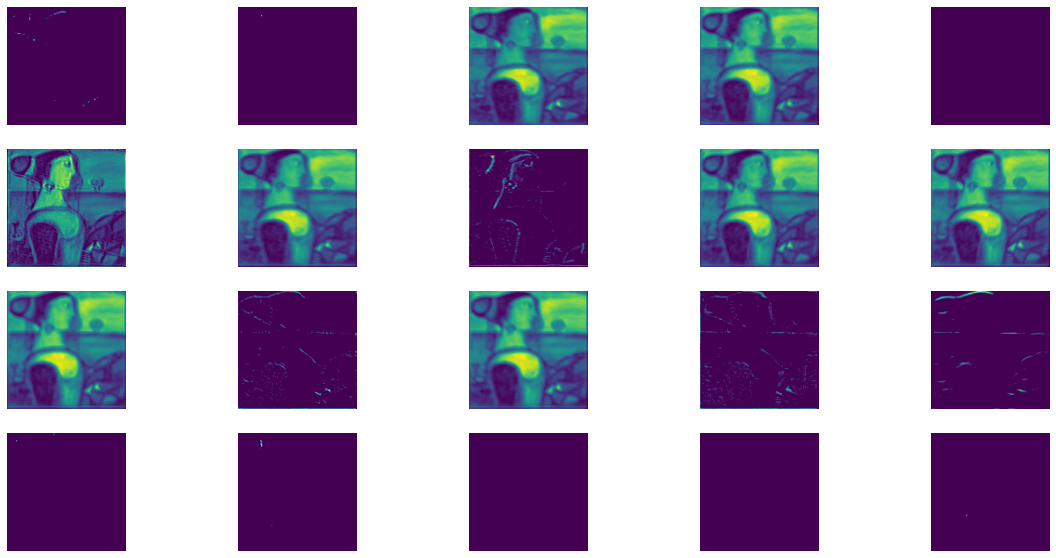

In [ ]:
i=14
layer=0

conv1 = model.layers[layer](X_train[i:(i+1)]*255)

plt.figure(figsize=(20, 10))
for k in range(20):
  plt.subplot(4, 5, k+1)  
  plt.imshow(conv1[0,:,:,k]) 
  plt.axis('off')

In [ ]:
model = load_model(path+"checkpoint_mejor_modelo_v1.h5")

In [ ]:
acc=model.evaluate(X_train,Y_train)
print(f"EL modelo arrojó un Accuracy en el set de entrenamiento de: {acc}")

7/7 [==============================] - 1s 160ms/step - loss: 1.2459 - accuracy: 0.6566
EL modelo arrojó un Accuracy en el set de entrenamiento de: [1.2459031343460083, 0.6565656661987305]


In [ ]:
acc=model.evaluate(X_test,Y_test)
print(f"EL modelo arrojó un Accuracy en el set de validación de: {acc}")

5/5 [==============================] - 1s 152ms/step - loss: 2.0764 - accuracy: 0.3788
EL modelo arrojó un Accuracy en el set de validación de: [2.076367139816284, 0.3787878751754761]
